<a href="https://colab.research.google.com/github/kartoniks/Studia/blob/master/Assignment2_Derechowski_Artur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2

**Submission deadline: last lab session before or on Thursday, 26.03.2020**

**Points: 6 + 1 bonus points**

## Submission instructions
The class is held remotely. To sumbmit your solutions please save the notebook to your Google Drive, then:
1. Rename it it to: Assignment2_Surname_FirstName
2. Rerun the whole notebook `Runtime -> Restar and run all`
3. Make a pinned revision `File->Save and pin revision`
4. Share the notebook with your instructor using his `cs.uni.wroc.pl` email

We will use the commenting system and video conferences to check and discuss the solutions.

As always, please submit corrections using GitHub's Pull Requests.

In [0]:
%matplotlib inline

In [0]:
import numpy as np
import matplotlib.pyplot as plt

The code below contains a mock-up of a two-layer neural network. Fill in the code and manually set weights to solve the XOR problem.

Please note: the shapes are set to be compatible with PyTorch's conventions:
* a batch containing $N$ $D$-dimensional examples has shape $N\times D$ (each example is a row!)
* a weight matrix in a linear layer with $I$ inputs and $O$ outputs has shape $O \times I$
* a bias vector is a 1D vector. Please note that [broadcasting rules](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) allow us to think about it as a $1 \times D` matrix.

Text(0, 0.5, 'X[1]')

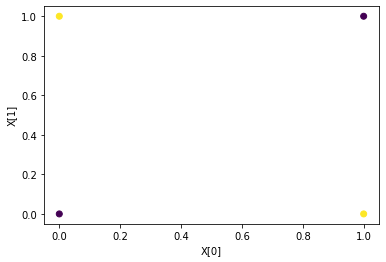

In [3]:
# Let's define a XOR dataset

# X will be matrix of N 2-dimensional inputs
X = np.array(
    [[0, 0],
     [0, 1],
     [1, 0],
     [1, 1],
    ], dtype=np.float32)
# Y is a matrix of N numners - answers
Y = np.array(
    [[0],
     [1],
     [1],
     [0],
    ], dtype=np.float32)

plt.scatter(X[:,0], X[:,1], c=Y[:,0], )
plt.xlabel('X[0]')
plt.ylabel('X[1]')

# Problem 1 [2p]

Fill in the details of a forward pass, then manually set the weights and biases in the network to solve the 2D XOR task defined above.

In [0]:
def sigmoid(x):
    return 1/(1 + np.exp(-x)) #DONE

class SmallNet:
    def __init__(self, in_features, num_hidden, dtype=np.float32):
        self.W1 = np.zeros((num_hidden, in_features), dtype=dtype)
        self.b1 = np.zeros((num_hidden,), dtype=dtype)
        self.W2 = np.zeros((1, num_hidden), dtype=dtype)
        self.b2 = np.zeros((1,), dtype=dtype)
        self.init_params()

    def init_params(self):
        # DONE Problem 2:
        # set all parameters to small random values, e.g. from N(0, 0.5)
        self.W1 = np.random.rand(self.W1.shape[0], self.W1.shape[1])-0.5
        self.b1 = np.random.rand(self.b1.shape[0],)-0.5
        self.W2 = np.random.rand(1, self.W2.shape[1])-0.5
        self.b2 = np.random.rand(1,)-0.5
        pass

    def forward(self, X, Y=None, do_backward=False):
        # TODO Problem 1: Fill in details of forward propagation

        # Input to neurons in 1st layer
        A1 = X @ self.W1.T + self.b1
        # print(A1)
        # Outputs after the sigmoid non-linearity
        O1 = sigmoid(A1)
        # Inputs to neuron in the second layer
        # print(O1)
        A2 = O1 @ self.W2.T + self.b2
        # Outputs after the sigmoid non-linearity
        O2 = sigmoid(A2)

        if Y is not None:
            # cross entropy loss
            loss = - Y*np.log(O2) - (1-Y)*np.log(1-O2)
            # normalize loss by batch size
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            # TODO in Problem 2: fill in the gradient computation
            # Please note, thate there is a correspondance between
            # the forward and backward pass: with backward computations happening
            # in reversed order. 

            # A2_grad is the gradient of loss with respect to A2
            # Hint: there is a concise formula for the gradient 
            # of logistic sigmoid and cross-entropy loss 
            batch_size = X.shape[0]
            O2_grad = - Y / (O2 + 1e-100) + (1-Y)/(1-O2+1e-100)
            A2_grad = O2_grad * O2 * (1- O2) / batch_size
            self.b2_grad = A2_grad.sum(0)
            self.W2_grad = A2_grad.T @ O1
            O1_grad = A2_grad * self.W2
            A1_grad = O1_grad * O1 * (1 - O1)
            self.b1_grad = A1_grad.sum(0)
            self.W1_grad = A1_grad.T @ X
            pass
        return O2, loss

In [5]:
# DONE Problem 1:
# Set by hand the weight values to solve the XOR problem

net = SmallNet(2, 2, dtype=np.float64)
net.W1 = np.array([[10.,10.],[10.,10.]])
net.b1 = np.array([-5.,-15.])
net.W2 = np.array([[10.,-10.]])
net.b2 = np.array([-5.])

# Hint: since we use the logistic sigmoid activation, the weights may need to 
# be fairly large 


net.forward(X, Y, do_backward=True)

(array([[0.00715279],
        [0.99235586],
        [0.99235586],
        [0.00715279]]), 0.0074259970019481605)

# Problem 2 [2p]

1. Fill in the backward pass.
2. Implement random initialization of network parameters.
3. Using `float64` verify correctness of your backward pass.

In [0]:
def check_grad(net, param_name, X, Y, eps=1e-5):
    """A gradient checking routine"""
    
    param = getattr(net, param_name)
    param_flat_accessor = param.reshape(-1)

    grad = np.empty_like(param)
    grad_flat_accessor = grad.reshape(-1)

    net.forward(X, Y, do_backward=True)
    orig_grad = getattr(net, param_name + '_grad')
    assert (param.shape == orig_grad.shape)

    for i in range(param_flat_accessor.shape[0]):
        orig_val = param_flat_accessor[i]
        param_flat_accessor[i] = orig_val + eps
        _, loss_positive = net.forward(X, Y)
        param_flat_accessor[i] = orig_val - eps
        _, loss_negative = net.forward(X, Y)
        param_flat_accessor[i] = orig_val
        grad_flat_accessor[i] = (
            loss_positive - loss_negative) / (2 * eps)
    assert np.allclose(grad, orig_grad)
    return grad, orig_grad

In [0]:
net = SmallNet(2, 2, dtype=np.float64)

for param_name in ['W1', 'b1', 'W2', 'b2']:
    check_grad(net, param_name, X, Y)

# Problem 3 [2p]

Fill in the details of batch gradient descent below, then train a network to solve 2D XOR problem.

Then test the reliability of solving the 3D XOR task.

In [15]:
net = SmallNet(2, 10, dtype=np.float64)

alpha = 1e-1

for i in range(100000):
    _, loss = net.forward(X, Y, do_backward=True)
    if (i % 5000) == 0:
        print(i, loss)
    for param_name in ['W1', 'b1', 'W2', 'b2']:
        param = getattr(net, param_name)
        grad = getattr(net, param_name+'_grad')
        # Hint: use the construct `param[:]` to change the contents of the array!
        # Doing instead `param = new_val` simply changes to what the variable
        # param points to, without affecting the network!
        param[:] = param - alpha*grad

0 0.7214894294565767
5000 0.09035565668106316
10000 0.01340624458614087
15000 0.006756979042049487
20000 0.004444429359132327
25000 0.003288401769056047
30000 0.002599914008490846
35000 0.0021448879587223474
40000 0.0018226102684420842
45000 0.0015827981534937319
50000 0.0013976186785228774
55000 0.0012504479646805464
60000 0.001130758589687894
65000 0.001031566648806916
70000 0.000948060341655601
75000 0.0008768186058376111
80000 0.0008153438130762401
85000 0.0007617706898728552
90000 0.0007146786159370482
95000 0.0006729669156857783


In [10]:
net.forward(X, Y, do_backward=True)

(array([[5.18711593e-04],
        [9.99448398e-01],
        [9.99493493e-01],
        [5.13202813e-04]]), 0.0005226425651728018)

Generate below data for a 3D XOR task. Try a few values of hidden layer size. Plot the reliability of training, i.e. how many trainings succeed for a given hiden layer size.

What is easier to train: a smaller, or large network?

In [25]:
X3 = np.array(
    [[0, 0, 0],
     [0, 1, 0],
     [1, 0, 0],
     [1, 1, 0],
     [0, 0, 1],
     [0, 1, 1],
     [1, 0, 1],
     [1, 1, 1],
    ], dtype=np.float32)
Y3 = np.array(
    [[0],
     [1],
     [1],
     [0],
     [1],
     [0],
     [0],
     [1],
    ], dtype=np.float32)

def train(hidden_no):
    net = SmallNet(3, hidden_no, dtype=np.float64)
    alpha = 1e-1

    for i in range(100000):
        _, loss = net.forward(X3, Y3, do_backward=True)
        for param_name in ['W1', 'b1', 'W2', 'b2']:
            param = getattr(net, param_name)
            grad = getattr(net, param_name+'_grad')
            param[:] = param - alpha*grad
    print(hidden_no, loss)
    res, loss = net.forward(X3, Y3, do_backward=True)
    # print(res)
    good = 0
    for i in range(len(Y3)):
        if Y3[i] == np.round(res[i]):
            good +=1
    print("guess percent: ", good/len(Y3))


for hidden_dim in [2, 3, 5, 10, 20]:
    # TODO: run a few trainings and record the fraction of successful ones
    train(hidden_dim)

2 0.6931271700009811
guess percent:  0.5
3 0.0016244232248809123
guess percent:  1.0
5 0.0007076094665467624
guess percent:  1.0
10 0.0005501996126055766
guess percent:  1.0
20 0.0006589225079548758
guess percent:  1.0


# Problem 4 [1bp]

Replace the first nonlinearity with the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation function. Verify ho

In [34]:
def ReLU(x):
    return np.maximum(0,x)

def reluDerivative(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

class ReLUNet:
    def __init__(self, in_features, num_hidden, dtype=np.float32):
        self.W1 = np.zeros((num_hidden, in_features), dtype=dtype)
        self.b1 = np.zeros((num_hidden,), dtype=dtype)
        self.W2 = np.zeros((1, num_hidden), dtype=dtype)
        self.b2 = np.zeros((1,), dtype=dtype)
        self.init_params()

    def init_params(self):
        # DONE Problem 2:
        # set all parameters to small random values, e.g. from N(0, 0.5)
        self.W1 = np.random.rand(self.W1.shape[0], self.W1.shape[1])-0.5
        self.b1 = np.random.rand(self.b1.shape[0],)-0.5
        self.W2 = np.random.rand(1, self.W2.shape[1])-0.5
        self.b2 = np.random.rand(1,)-0.5
        pass

    def forward(self, X, Y=None, do_backward=False):
        # TODO Problem 1: Fill in details of forward propagation

        # Input to neurons in 1st layer
        A1 = X @ self.W1.T + self.b1
        # print(A1)
        # Outputs after the sigmoid non-linearity
        O1 = ReLU(A1)
        # Inputs to neuron in the second layer
        # print(O1)
        A2 = O1 @ self.W2.T + self.b2
        # Outputs after the sigmoid non-linearity
        O2 = sigmoid(A2)

        if Y is not None:
            # cross entropy loss
            loss = - Y*np.log(O2) - (1-Y)*np.log(1-O2)
            # normalize loss by batch size
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            # TODO in Problem 2: fill in the gradient computation
            # Please note, thate there is a correspondance between
            # the forward and backward pass: with backward computations happening
            # in reversed order. 

            # A2_grad is the gradient of loss with respect to A2
            # Hint: there is a concise formula for the gradient 
            # of logistic sigmoid and cross-entropy loss 
            batch_size = X.shape[0]
            O2_grad = - Y / (O2 + 1e-100) + (1-Y)/(1-O2+1e-100)
            A2_grad = O2_grad * O2 * (1- O2) / batch_size
            self.b2_grad = A2_grad.sum(0)
            self.W2_grad = A2_grad.T @ O1
            O1_grad = A2_grad * self.W2
            A1_grad = O1_grad * reluDerivative(O1)
            self.b1_grad = A1_grad.sum(0)
            self.W1_grad = A1_grad.T @ X
            pass
        return O2, loss

net = SmallNet(2, 10, dtype=np.float64)
r_net = ReLUNet(2, 10, dtype=np.float64)
alpha = 1e-1

for i in range(100000):
    _, loss = net.forward(X, Y, do_backward=True)
    _, r_loss = r_net.forward(X, Y, do_backward=True)
    if (i % 5000) == 0:
        print(i, "normal loss: ", loss, "   ReLU loss: ", r_loss)
    for param_name in ['W1', 'b1', 'W2', 'b2']:
        param = getattr(net, param_name)
        grad = getattr(net, param_name+'_grad')
        r_param = getattr(r_net, param_name)
        r_grad = getattr(r_net, param_name+'_grad')
        param[:] = param - alpha*grad
        r_param[:] = r_param - alpha*r_grad

0 normal loss:  0.6949112700440088    ReLU loss:  0.7098310247124273
5000 normal loss:  0.25862409859235475    ReLU loss:  0.001823538747412883
10000 normal loss:  0.018461379974080157    ReLU loss:  0.0007242890659516104
15000 normal loss:  0.007868613749710533    ReLU loss:  0.0004346217603402281
20000 normal loss:  0.0047974654047183    ReLU loss:  0.00030524882440037234
25000 normal loss:  0.0033910181694076598    ReLU loss:  0.0002330355896274761
30000 normal loss:  0.002597763224705745    ReLU loss:  0.00018733932810699274
35000 normal loss:  0.0020931580619432616    ReLU loss:  0.0001559938171406502
40000 normal loss:  0.0017459352494904176    ReLU loss:  0.00013324359289664816
45000 normal loss:  0.0014934047546703404    ReLU loss:  0.0001160255427005763
50000 normal loss:  0.0013020284629158875    ReLU loss:  0.00010256595819857717
55000 normal loss:  0.001152314514697662    ReLU loss:  9.178068226495173e-05
60000 normal loss:  0.001032194788390951    ReLU loss:  8.29502689178